# Single cell analysis

In [1]:
# try:
#     import varseek as vk
# except ImportError:
#     print("varseek not found, installing...")
#     !pip install -U -q varseek
# try:
#     import RLSRWP_2025
# except ImportError:
#     print("RLSRWP_2025 not found, installing...")
#     !pip install -q git+https://github.com/pachterlab/RLSRWP_2025.git
# try:
#     import gget
# except ImportError:
#     print("gget not found, installing...")
#     !pip install -U -q gget

In [ ]:
import os
import anndata as ad
import pandas as pd
import gget
import subprocess
import ast
import numpy as np
import varseek as vk
from RLSRWP_2025.constants import box_links_dict

RLSRWP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRWP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRWP_2025

In [30]:
n = 3
sorting_column = "vcrs_count"  # "vcrs_count" (sort by variant), "gene_count" (sort by gene), etc

vk_count_out_dir = os.path.join(RLSRWP_2025_dir, "data", "vk_count_out_fig1")
adata_path = os.path.join(vk_count_out_dir, "adata_cleaned.h5ad")
adata_reference_genome_path = os.path.join(vk_count_out_dir, "adata_reference_genome_cleaned.h5ad")

out_dir = os.path.join(vk_count_out_dir, "analysis", "single_cell_analysis")

cbioportal_mutated_genes_path = os.path.join(out_dir, "Mutated_Genes.txt")
gbm_metadata_path = os.path.join(out_dir, "GBM_metadata.csv")

reference_dir = os.path.join(RLSRWP_2025_dir, "data", "reference")
cosmic_csv = os.path.join(reference_dir, "cosmic", "CancerMutationCensus_AllData_Tsv_v101_GRCh37", "CancerMutationCensus_AllData_v101_GRCh37_mutation_workflow.csv")
sequences_cds = os.path.join(reference_dir, "ensembl_grch37_release93", "Homo_sapiens.GRCh37.cds.all.fa")
sequences_cdna = os.path.join(reference_dir, "ensembl_grch37_release93", "Homo_sapiens.GRCh37.cdna.all.fa")

Download data

In [ ]:
if not os.path.isfile(adata_path):
    vk.utils.download_box_url(box_links_dict["glioblastoma_smartseq_adata_vcrs"], output_file_name=adata_path)
if not os.path.isfile(adata_reference_genome_path):
    vk.utils.download_box_url(box_links_dict["glioblastoma_smartseq_adata_reference_genome"], output_file_name=adata_reference_genome_path)
if not os.path.isfile(cosmic_csv):
    vk.utils.download_box_url(box_links_dict["cosmic_csv"], output_file_name=cosmic_csv)
if not os.path.isfile(gbm_metadata_path):
    vk.utils.download_box_url(box_links_dict["gbm_metadata"], output_file_name=gbm_metadata_path)
if not os.path.isfile(cbioportal_mutated_genes_path):
    vk.utils.download_box_url(box_links_dict["cbioportal_mutated_genes"], output_file_name=cbioportal_mutated_genes_path)

os.makedirs(out_dir, exist_ok=True)

In [38]:
adata = ad.read_h5ad(adata_path)
adata_reference_genome = ad.read_h5ad(adata_reference_genome_path)

cosmic_df = pd.read_csv(cosmic_csv)
metadata_df = pd.read_csv(gbm_metadata_path, sep=" ")
cbioportal_mutated_genes_df = pd.read_csv(cbioportal_mutated_genes_path, sep="\t")

In [39]:
adata.var.head(2)

,vcrs_id,vcrs_header,seq_ID,mutation_cdna,nucleotide_positions,actual_variant,start_variant_position,end_variant_position,variant_source,gene_name,vcrs_header_with_gene_name,vcrs_count,vcrs_detected,gene_count,number_obs
variant,,,,,,,,,,,,,,,
ENST00000391429:c.194C>T,ENST00000391429:c.194C>T,ENST00000391429:c.194C>T,ENST00000391429,c.194C>T,194,C>T,194.0,194.0,transcriptome,ENSG00000205899,ENSG00000205899(ENST00000391429):c.194C>T,0.0,False,0,0
ENST00000391429:c.128C>A,ENST00000391429:c.128C>A,ENST00000391429:c.128C>A,ENST00000391429,c.128C>A,128,C>A,128.0,128.0,transcriptome,ENSG00000205899,ENSG00000205899(ENST00000391429):c.128C>A,0.0,False,0,0


In [40]:
adata = adata[:, np.array((adata.X != 0).sum(axis=0)).flatten() > 0]  # Identify columns (variants) with non-zero counts across samples
adata = adata[:, ~adata.var_names.str.contains(";")]  # Identify columns (variants) with semicolon in name
adata.var = adata.var.drop(columns=["vcrs_id", "vcrs_detected", "variant_source"])  # drop vcrs_id (because it is a duplicate of vcrs_header)
adata.var = adata.var.rename(columns={"vcrs_header": "variant_name", "gene_name": "gene_id", "vcrs_header_with_gene_name": "variant_name_with_gene_id", "vcrs_count": "variant_count"})
adata.var = adata.var.merge(cosmic_df[["seq_ID", "gene_name"]].drop_duplicates("seq_ID"), on="seq_ID", how="left").rename(columns={"gene_name": "gene_symbol"})

adata.var["VAF"] = adata.var["number_obs"] / adata.shape[0]  # fraction of cells with variant

adata.var['variant_name_with_gene_name'] = (
    adata.var["gene_symbol"] + "(" +
    adata.var["variant_name"].str.split(":").str[0] + "):" +
    adata.var["variant_name"].str.split(":").str[1]
)


# reorder columns in adata.var
priority_cols = [
    "variant_name",
    "gene_symbol",
    "variant_count",
    "gene_count",
    "number_obs",
    "VAF"
]

# Get the remaining columns not in the priority list
remaining_cols = [col for col in adata.var.columns if col not in priority_cols]

# Reorder adata.var
adata.var = adata.var[priority_cols + remaining_cols]

In [41]:
adata.var.head()

,variant_name,gene_symbol,variant_count,gene_count,number_obs,VAF,seq_ID,mutation_cdna,nucleotide_positions,actual_variant,start_variant_position,end_variant_position,gene_id,variant_name_with_gene_id,variant_name_with_gene_name
0,ENST00000396153:c.1592C>T,FAF1,3.0,49,1,0.000279,ENST00000396153,c.1592C>T,1592,C>T,1592.0,1592.0,ENSG00000185104,ENSG00000185104(ENST00000396153):c.1592C>T,FAF1(ENST00000396153):c.1592C>T
1,ENST00000396153:c.2261A>G,FAF1,5.0,49,2,0.000557,ENST00000396153,c.2261A>G,2261,A>G,2261.0,2261.0,ENSG00000185104,ENSG00000185104(ENST00000396153):c.2261A>G,FAF1(ENST00000396153):c.2261A>G
2,ENST00000396153:c.1823G>A,FAF1,5.0,49,1,0.000279,ENST00000396153,c.1823G>A,1823,G>A,1823.0,1823.0,ENSG00000185104,ENSG00000185104(ENST00000396153):c.1823G>A,FAF1(ENST00000396153):c.1823G>A
3,ENST00000396153:c.1391G>T,FAF1,2.0,49,1,0.000279,ENST00000396153,c.1391G>T,1391,G>T,1391.0,1391.0,ENSG00000185104,ENSG00000185104(ENST00000396153):c.1391G>T,FAF1(ENST00000396153):c.1391G>T
4,ENST00000396153:c.1325C>T,FAF1,3.0,49,1,0.000279,ENST00000396153,c.1325C>T,1325,C>T,1325.0,1325.0,ENSG00000185104,ENSG00000185104(ENST00000396153):c.1325C>T,FAF1(ENST00000396153):c.1325C>T


In [42]:
cbioportal_mutated_genes_df.head()

,Gene,MutSig(Q-value),# Mut,#,Profiled Samples,Freq,Is Cancer Gene (source: OncoKB)
0,HTR4,NaN,4,3,397,0.8%,No
1,HTR7,NaN,5,5,397,1.3%,No
2,LURAP1L,NaN,1,1,397,0.3%,No
3,BBX,NaN,3,3,397,0.8%,No
4,SPATA31G1,NaN,11,7,397,1.8%,No


## From their paper, Fig2a

In [48]:
cluster_color_to_identity_dict = {
    "1": "Neoplastic cells 1",  # cluster 1 from picture (counting from top left, going down and the across)
    "2": "Oligodendrocytes",  # cluster 10 from picture
    "3": "Vascular cells 1",  # cluster 4
    "4": "Neoplastic cells 2",  # cluster 2
    "5": "Neurons",  # cluster 9
    "6": "Vascular cells 2",  # cluster 5
    "7": "Myeloid cell 1",  # cluster 7
    "8": "Myeloid cell 2",  # cluster 8
    "9": "OPCs",  # cluster 11
    "10": "Astrocytes",  # cluster 12
    "11": "Neoplastic cells 3",  # cluster 3
    "12": "Vascular cells 3",  # cluster 6
}

metadata_df[['Cluster_2d', 'Cluster_2d_color']].drop_duplicates().sort_values('Cluster_2d')

,Cluster_2d,Cluster_2d_color
1001000175.F12,1,#1F77B4
1001000173.D4,2,#AEC7E8
1001000175.B6,3,#FF7F0E
1001000258.F11,4,#FFBB78
1001000175.H9,5,#2CA02C
1001000031.C5,6,#98DF8A
1001000173.D11,7,#D62728
1001000173.B6,8,#FF9896
1001000173.D6,9,#9467BD
1001000180.G9,10,#C5B0D5


# Histograms

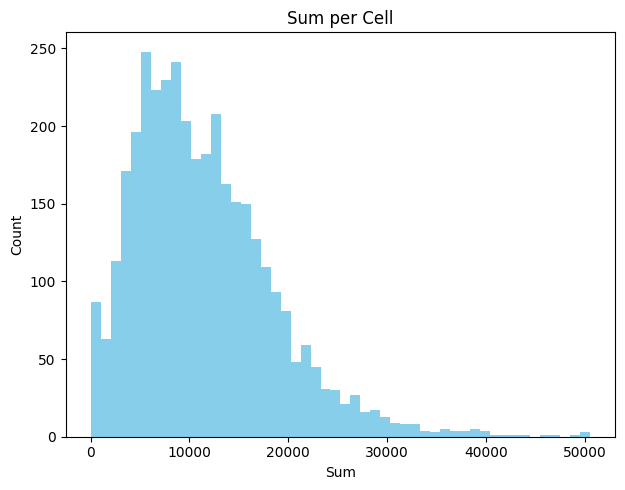

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Sum across rows (per cell)
row_sums = adata.X.sum(axis=1).A1 if hasattr(adata.X, "A1") else np.ravel(adata.X.sum(axis=1))

# Sum across columns (per gene)
col_sums = adata.X.sum(axis=0).A1 if hasattr(adata.X, "A1") else np.ravel(adata.X.sum(axis=0))

# Plot histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(row_sums, bins=50, color='skyblue')
plt.title('Sum per Cell')
plt.xlabel('Sum')
plt.ylabel('Count')

# plt.subplot(1, 2, 2)
# plt.hist(col_sums, bins=50, color='salmon')
# plt.title('Sum per Gene')
# plt.xlabel('Sum')
# plt.ylabel('Count')

plt.tight_layout()
plt.show()


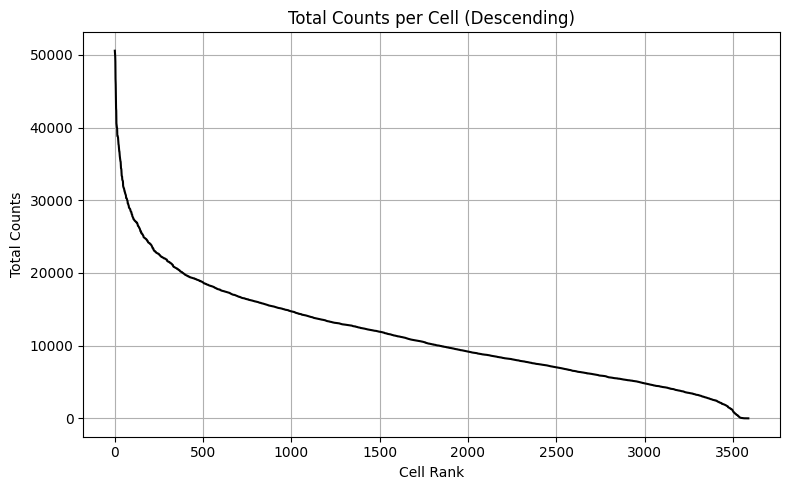

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Compute sum per cell (rows)
row_sums = adata.X.sum(axis=1).A1 if hasattr(adata.X, "A1") else np.ravel(adata.X.sum(axis=1))

# Sort descending
sorted_sums = np.sort(row_sums)[::-1]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(sorted_sums, color='black')
plt.title("Total Counts per Cell (Descending)")
plt.xlabel("Cell Rank")
plt.ylabel("Total Counts")
plt.grid(True)
plt.tight_layout()
plt.show()


# sort descending by # Mut, and keep only those with at least 20 value

In [ ]:
# cbioportal_mutated_genes_df_filtered = 

# Convert ENSG to gene symbols

In [ ]:
# adata.var['gene_symbol']  # adata.var['gene_name']

In [ ]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

## assign oncogene vs tumor suppressor gene - I expect oncogenes to be more prevelant in mutation data

## Calculate VAF in the cancer cells as a way to try to understand which mutations may be most interesting